In [1]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import YouTubeVideo
from PIL import Image

# Convolutional filters

We will apply following filters in sliding fashion

![Convolution filter](https://cdn-images-1.medium.com/max/900/1*7S266Kq-UCExS25iX_I_AQ.png)

![Cinvolution animation](https://deeplizard.com/images/same_padding_no_strides.gif)

In [5]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()
    
    return X_with_filter

Let's load an image and apply different filter on it.

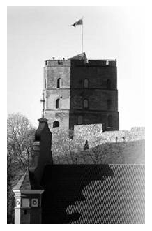

In [6]:
img = Image.open('img/castle.jpg')
img.load()
X = np.asarray(img, dtype="int32") / 255
# X = X.mean(axis=2) / 255
plot(X)

## Simple box blur

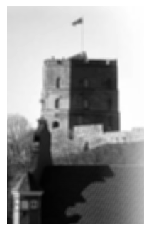

In [16]:
F = np.ones(shape=(5, 5)) / 25
plot(apply_filter(X, F))

## Line detection

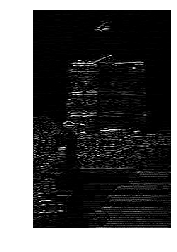

In [81]:
F = np.array([[-1, -1, -1],
              [ 2,  2,  2],
              [-1, -1, -1]])
plot(apply_filter(X, F))

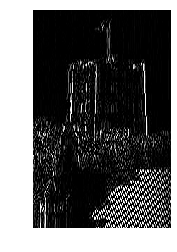

In [82]:
F = np.array([[-1, 2, -1],
              [-1, 2, -1],
              [-1, 2, -1]])
plot(apply_filter(X, F))

## Edge detection

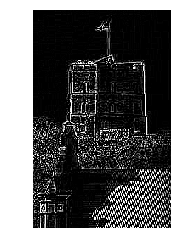

In [83]:
F = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])
plot(apply_filter(X, F))

## The Sobel Edge Operator

We can combine muliple filters to obtain something more interesting. This hints that neural network with multiple layers can extract and focus on important details.

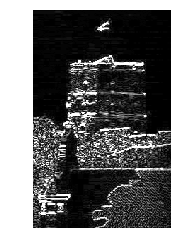

In [86]:
F_horizontal = np.array([[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]])
F_vertical = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])
plot(np.sqrt(apply_filter(X, F_horizontal)**2 + apply_filter(X, F_vertical)**2))

## MaxPooling

MaxPooling is a simple way to compress image without loosing most important details. We will use it to speed up training process sometimes.

Original shape: (312, 198), after MaxPooling: (156, 99)


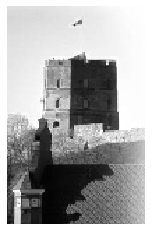

In [14]:
x, y = X.shape
X_pooled = np.zeros(shape=(x//2, y//2))

for i in range(x//2):
    for j in range(y//2):
        X_pooled[i, j] = np.max(X[i*2:i*2+2, j*2:j*2+2])

print('Original shape: {0}, after MaxPooling: {1}'.format(X.shape, X_pooled.shape))
plot(X_pooled)

# CNN

We will discuss how CNN works in a lecture, but if you want more detailed explanation this [blog post](https://engmrk.com/convolutional-neural-network-3/) is really good.

Let's try convolutional layers on MNIST dataset.

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# Normalize (note that we add channel)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255

In [114]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[28, 28, 1]))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1843300   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 1,853,878
Trainable params: 1,853,878
Non-trainable params: 0
_________________________________________________________________


In [115]:
loss = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 68s 1ms/step - loss: 0.3984 - acc: 0.8854 - val_loss: 0.1903 - val_acc: 0.9450
Epoch 2/10
48000/48000 [==============================] - 67s 1ms/step - loss: 0.1673 - acc: 0.9500 - val_loss: 0.1482 - val_acc: 0.9563
Epoch 3/10
48000/48000 [==============================] - 78s 2ms/step - loss: 0.1228 - acc: 0.9630 - val_loss: 0.1101 - val_acc: 0.9674
Epoch 4/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.0989 - acc: 0.9700 - val_loss: 0.1002 - val_acc: 0.9710
Epoch 5/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0818 - acc: 0.9752 - val_loss: 0.0952 - val_acc: 0.9728
Epoch 6/10
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0702 - acc: 0.9781 - val_loss: 0.0929 - val_acc: 0.9714
Epoch 7/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0833 - val_acc

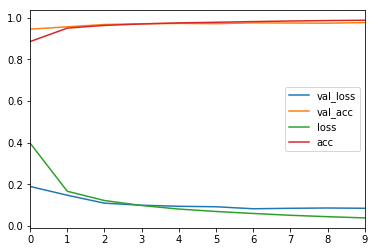

In [116]:
pd.DataFrame(loss.history).plot()

Using FCN we had 96.36% on test set, thus we have improved our NN.

In [117]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

Accuracy on test set - 97.72%


# What's next?

There are multiple other tricks (Dropout, MaxPooling, ...) which can increse performance even more, but general CNN principle is still leading solution in image recognition.

In 1998 LeCun introduced legenary [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) which is perhaps the most widely known CNN architecture

![LeNet-5](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

For more detail and examples see [LeCun website](http://yann.lecun.com/exdb/lenet/index.html).

Then, ImageNet competition was created and it enhanced further evolution of CNN's.

![ImageNet](http://ruder.io/content/images/2018/07/imagenet_challenge.png)

In 2012 Hinton team managed to win ImageNet competition with new archtecture called [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks). 

![AlexNet](https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png)

At the time this was a vast improvement over shallow networks.

![Scores](https://miro.medium.com/max/1442/1*DBXf6dzNB78QPHGDofHA4Q.png)

By the way, humans were also scored on ImageNet and tey can achieve ~5, thus current networks can beat humans on image comprehension! If you are interested about further evolution of ImageNet competition see [this website](https://paperswithcode.com/sota/image-classification-on-imagenet).

## Hybrid implementation

Following implementation is a combination of techniques mentioned above and works great for MNIST.

**NOTE:** LONG TRAINING TIME!

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[28, 28, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

Let's add logger so that we can check outputs in tensorboard. To run tensorboard use: `tensorboard --logdir=./my_logs --port=6006`.

In [23]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = TensorBoard(run_logdir)

In [24]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[tensorboard_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 87s 2ms/step - loss: 0.2842 - acc: 0.9127 - val_loss: 0.0660 - val_acc: 0.9810
Epoch 2/10
48000/48000 [==============================] - 87s 2ms/step - loss: 0.0962 - acc: 0.9714 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 3/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0699 - acc: 0.9789 - val_loss: 0.0431 - val_acc: 0.9870
Epoch 4/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0592 - acc: 0.9820 - val_loss: 0.0375 - val_acc: 0.9878
Epoch 5/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0468 - acc: 0.9858 - val_loss: 0.0372 - val_acc: 0.9881
Epoch 6/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.0406 - acc: 0.9871 - val_loss: 0.0356 - val_acc: 0.9904
Epoch 7/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0379 - acc: 0.9882 - val_loss: 0.0337 - val_acc

Go to [tensorboard](http://localhost:6006) and familarize with it while model is training.

In [25]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

Accuracy on test set - 99.25%
